## Import Packages

In [4]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


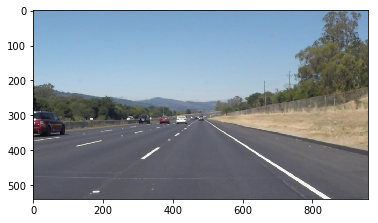

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [150]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [2]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



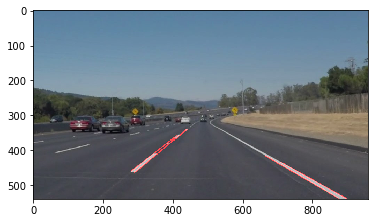

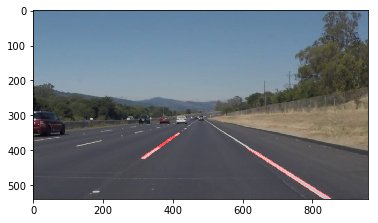

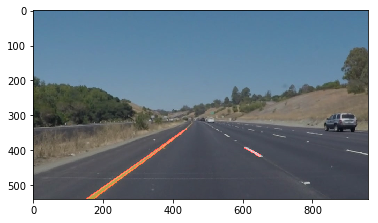

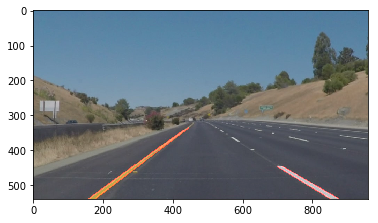

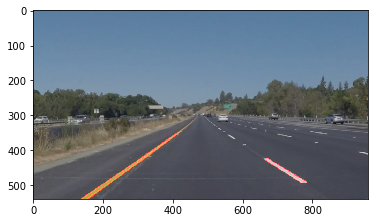

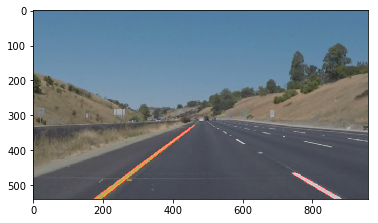

In [141]:
# PIPELINE IMPLEMENTATION

def draw_lane_lines(image):
    
    # Greyscale image
    greyscaled_image = grayscale(image)
    
    # Gaussian Blur
    blurred_grey_image = gaussian_blur(greyscaled_image, 5)
    
    # Canny edge detection
    edges_image = canny(blurred_grey_image, 50, 150)

    # Mask image, TODO: these are hardcoded
    imshape = image.shape
    border = 0
    vertices = np.array([[(0,imshape[0]),(460, 330), (460, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_image_with_mask = region_of_interest(edges_image, vertices)
    
    # Hough lines
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 40     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 20 #minimum number of pixels making up a line
    max_line_gap = 40    # maximum gap in pixels between connectable line segments
    lines_image = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)

    final_image = weighted_img(lines_image, image)
    
    result = final_image
    return result

for image in os.listdir("test_images/"):
    path = mpimg.imread('test_images/' + image)
    processed_image = draw_lane_lines(path)
    plt.figure()
    plt.imshow(processed_image)


### Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [35]:
def process_image(image):
 
    result = draw_lane_lines(image)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [151]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,10)
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 250/251 [00:06<00:00, 36.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.81 s, sys: 808 ms, total: 3.62 s
Wall time: 7.34 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [152]:
HTML("""
<video width="560" height="360" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [144]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    slope = []
    posSlope = []
    negSlope = []
    yMax = img.shape[0]
    yMin = int(img.shape[0]/2) + 50
    yIntLeft = []
    yIntRight = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x2 - x1 != 0:
                m = (y2-y1)/(x2 - x1)
                b1 = y1 - m * x1
                b2 = y2 - m * x2
                slope.append(m)
                if (m >0.5) and (m <0.8):
                    posSlope.append(m)
                    yIntRight.append(b2)
                elif (m > -0.8) and (m < -0.5) and (b1 > 600):
                    negSlope.append(m)
                    yIntLeft.append(b2)
                    
    if len(posSlope) != 0 and len(negSlope) != 0 and len(yIntLeft) != 0 and len(yIntRight) != 0:
        avgPosSlope = sum(posSlope)/len(posSlope)
        avgNegSlope = sum(negSlope)/len(negSlope)
        avgLeftYInt = sum(yIntLeft)/len(yIntLeft)
        avgRightYInt = sum(yIntRight)/len(yIntRight)

        xMinLeft = int(yMin/avgNegSlope - avgLeftYInt/avgNegSlope)
        xMaxLeft = int(yMax/avgNegSlope - avgLeftYInt/avgNegSlope)
        xMinRight = int(yMin/avgPosSlope - avgRightYInt/avgPosSlope)
        xMaxRight = int(yMax/avgPosSlope - avgRightYInt/avgPosSlope)

        cv2.line(img, (xMinLeft, yMin), (xMaxLeft, yMax), color, thickness)
        cv2.line(img, (xMinRight, yMin), (xMaxRight, yMax), color, thickness)


In [145]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
# clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


 99%|█████████▉| 125/126 [00:02<00:00, 44.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 1.43 s, sys: 389 ms, total: 1.82 s
Wall time: 3.64 s


In [146]:
HTML("""
<video width="560" height="340" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [147]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,15)
# clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|█████████▉| 375/376 [00:19<00:00, 35.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 10.7 s, sys: 1.99 s, total: 12.7 s
Wall time: 20.1 s


In [148]:
HTML("""
<video width="560" height="340" controls>
  <source src="{0}">
</video>
""".format(challenge_output))